In [2]:
import torch  
from torch import nn  
from torch.nn import functional as F
import sys
sys.path.append('../') 
import utils as d2l

## 一、residual 
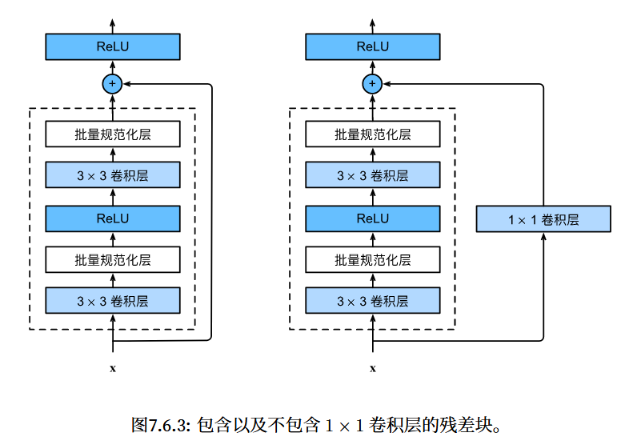

In [47]:
class Residual(nn.Module): #@save  
    def __init__(self, input_channels, num_channels,  use_1x1conv=False, strides=1):  
        super().__init__()  
        self.conv1 = nn.Conv2d(input_channels, num_channels,  kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,  kernel_size=3, padding=1)  
        if use_1x1conv:  
            self.conv3 = nn.Conv2d(input_channels, num_channels,  kernel_size=1, stride=strides)  
        else:  
            self.conv3 = None  
        self.bn1 = nn.BatchNorm2d(num_channels)  
        self.bn2 = nn.BatchNorm2d(num_channels)  
    def forward(self, X):  
        Y = F.relu(self.bn1(self.conv1(X)))  
        Y = self.bn2(self.conv2(Y))  
        if self.conv3:  
            X = self.conv3(X)  
        Y += X  # 加上X
        return F.relu(Y)

- use_1x1conv: change channels  when input_channels=!num_channels  or change w/h
- strides: change h and w

In [50]:
blk = Residual(3,3)  
X = torch.rand(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [52]:
blk = Residual(3,6, use_1x1conv=True, strides=1)  
blk(X).shape

torch.Size([4, 6, 6, 6])

In [54]:
blk = Residual(3,6, use_1x1conv=True, strides=2)  
blk(X).shape

torch.Size([4, 6, 3, 3])

## 二、Residual block

- first_block and other_block:
- 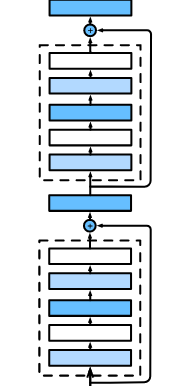 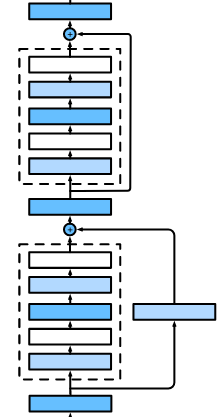

In [92]:
def resnet_block(input_channels, num_channels, num_residuals,  first_block=False):  
    blk = []  
    for i in range(num_residuals):  
        if i == 0 and not first_block:  
            blk.append(Residual(input_channels, num_channels,  use_1x1conv=True, strides=2))  
        else:  
            blk.append(Residual(num_channels, num_channels))  
    return blk

- num_residuals: in ResNet-18, it is 2;
- only  not first_block and first residual , use_1X1conv and strides=2
- first_block don't change channels and w/h, so input_channels=num_channels
- other_block can change num_channels and make w and h ->w/2 and h/2

## 三、ResNet‐18

1. 在输出通道数为64、步幅为2的7 × 7卷积层后,接步幅为2的3 × 3的最大汇聚层。

In [131]:
# input 1x224x224
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),  #64x112x112
                   nn.BatchNorm2d(64), nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))#64x56x56

2. ResNet-18使用4个由残差块(residual_block)组成,num_channels=2

In [134]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) #64x56x56
b3 = nn.Sequential(*resnet_block(64, 128, 2)) #128x28x28
b4 = nn.Sequential(*resnet_block(128, 256, 2)) #256x14x14
b5 = nn.Sequential(*resnet_block(256, 512, 2)) #512x7x7

In [136]:
net = nn.Sequential(b1, b2, b3, b4, b5,  
                    nn.AdaptiveAvgPool2d((1,1)), #512x1x1 
                    nn.Flatten(), #512
                    nn.Linear(512, 10))

In [138]:
X = torch.rand(size=(1, 1, 224, 224))  
for layer in net:  
    X = layer(X)  
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])
